# Imports
This cell imports the main libraries used throughout the notebook:
- `tensorflow` / `keras` for model building and training.
- `numpy` for numerical operations.
- `matplotlib` and `seaborn` for plotting.
- `sklearn.model_selection.train_test_split` for dataset splitting.
- `collections.Counter` to count labels and `os` for filesystem access.

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, ConvNeXtTiny
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import os

# Configuration / Hyperparameters
This cell defines constants used for training and reproducibility:
- Batch size, image dimensions, input shape.
- Random seed for reproducible splits and weight initialization.
- Number of epochs and learning rate for training.


In [36]:
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
SEED = 42
EPOCHS = 20
LEARNING_RATE = 1e-3
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Load dataset paths and labels
This cell scans the dataset directory and builds arrays of file paths and numeric labels:
- `class_names` is a sorted list of subfolders (one per class).
- `class_to_idx` maps class name → integer label.
- `all_images` and `all_labels` collect every image path and its label.
- The cell prints counts per class and total images so you can inspect dataset balance.

In [37]:
DATA_DIR = 'C:\\Users\\VIMALA SRI\\Desktop\\IntelligentDermaDiseaaseDetection\\Skin disease dataset\\IMG_CLASSES'
all_images = []
all_labels = []
class_names = sorted(os.listdir(DATA_DIR))
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

print(f"\nScanning directory: {DATA_DIR}")
print(f"Found {len(class_names)} classes")
print(f"Classes: {class_names}")

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue
    
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(class_dir, img_name)
            all_images.append(img_path)
            all_labels.append(class_to_idx[class_name])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(f"\nTotal images found: {len(all_images)}")
print(f"Number of classes: {len(class_names)}")
class_counts = Counter(all_labels)
for idx, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_counts[idx]} images")


Scanning directory: C:\Users\VIMALA SRI\Desktop\IntelligentDermaDiseaaseDetection\Skin disease dataset\IMG_CLASSES
Found 10 classes
Classes: ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']

Total images found: 27153
Number of classes: 10
  1. Eczema 1677: 1677 images
  10. Warts Molluscum and other Viral Infections - 2103: 2103 images
  2. Melanoma 15.75k: 3140 images
  3. Atopic Dermatitis - 1.25k: 1257 images
  4. Basal Cell Carcinoma (BCC) 3323: 3323 images
  5. Melanocytic Nevi (NV) - 7970: 7970 images
  6. Benign Keratosis-like Lesions (BKL) 2624: 2079 images
  7. Psoriasis pictures Lichen Plan

# Train / Validation / Test Split
This cell splits the dataset into train / validation / test sets using stratified sampling:
- First split: train vs (temp) where `test_size=0.2`.
- Second split: temp → validation and test with `test_size=0.5`, resulting in 10% validation and 10% test overall.
- `stratify` ensures class proportions remain similar across splits.
- The cell prints a short summary of split sizes.

In [38]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_images, 
    all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=SEED
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=SEED
)

print(f"\nSplit Summary:")
print(f"  Train: {len(train_paths)} images ({len(train_paths)/len(all_images)*100:.1f}%)")
print(f"  Validation: {len(val_paths)} images ({len(val_paths)/len(all_images)*100:.1f}%)")
print(f"  Test: {len(test_paths)} images ({len(test_paths)/len(all_images)*100:.1f}%)")


Split Summary:
  Train: 21722 images (80.0%)
  Validation: 2715 images (10.0%)
  Test: 2716 images (10.0%)


# Plot Class Distribution
This cell defines a helper function `plot_class_distribution` that:
- Counts how many images of each class exist in train / val / test.
- Draws a grouped bar chart so you can visually inspect class balance across splits.
- Finally it calls the function to show the plot for the current splits.

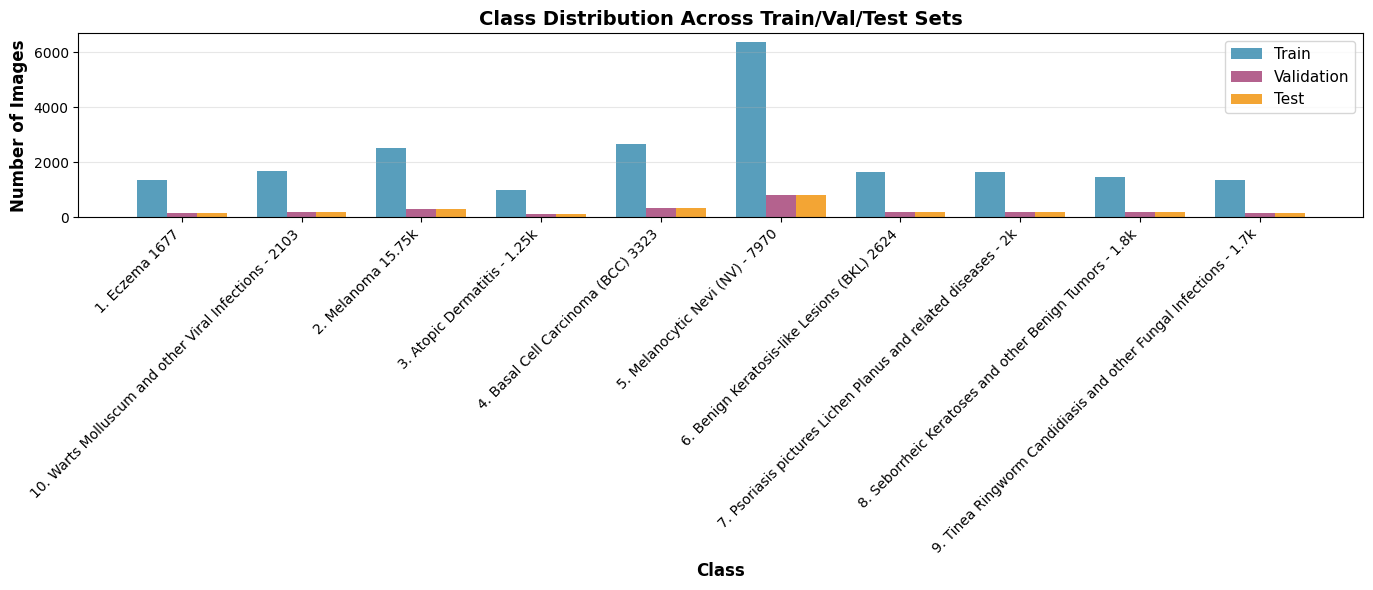


✓ Class distribution plotted successfully!


In [39]:
def plot_class_distribution(train_labels, val_labels, test_labels, class_names):
    """Plot class distribution across splits"""
    
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    test_counts = Counter(test_labels)
    
    # Prepare data for plotting
    x = np.arange(len(class_names))
    width = 0.25
    
    train_vals = [train_counts[i] for i in range(len(class_names))]
    val_vals = [val_counts[i] for i in range(len(class_names))]
    test_vals = [test_counts[i] for i in range(len(class_names))]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.bar(x - width, train_vals, width, label='Train', alpha=0.8, color='#2E86AB')
    ax.bar(x, val_vals, width, label='Validation', alpha=0.8, color='#A23B72')
    ax.bar(x + width, test_vals, width, label='Test', alpha=0.8, color='#F18F01')
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Class Distribution Across Train/Val/Test Sets', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Class distribution plotted successfully!")

plot_class_distribution(train_labels, val_labels, test_labels, class_names)

# Data Augmentation
This cell defines a Keras `Sequential` data-augmentation pipeline that will be applied to training images.
- `RandomFlip(
)`: randomly flips images horizontally.
- `RandomRotation(0.2)`: rotates images by up to 20%.
- `RandomZoom(0.2)`: randomly zooms in/out up to 20%.
- `RandomTranslation(0.1, 0.1)`: shifts images horizontally/vertically up to 10%.


In [40]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")

In [41]:
def create_dataset(image_paths, labels, preprocess_fn, augment=False, shuffle=True):
    """Create TF dataset from paths and labels"""
    
    def load_and_preprocess(path, label):
        # Read image
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, label
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=SEED)
    
    dataset = dataset.batch(BATCH_SIZE)
    
    # Apply augmentation
    if augment:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Apply preprocessing
    dataset = dataset.map(
        lambda x, y: (preprocess_fn(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return dataset.prefetch(tf.data.AUTOTUNE)

In [42]:
def preprocess_efficientnet(x):
    return tf.keras.applications.efficientnet.preprocess_input(x)

train_ds_eff = create_dataset(train_paths, train_labels, preprocess_efficientnet, augment=True, shuffle=True)
val_ds_eff = create_dataset(val_paths, val_labels, preprocess_efficientnet, augment=False, shuffle=False)
test_ds_eff = create_dataset(test_paths, test_labels, preprocess_efficientnet, augment=False, shuffle=False)

In [43]:
def build_efficientnet_model(num_classes):    
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=INPUT_SHAPE,
        pooling='avg'
    )
    base_model.trainable = False
    
    inputs = base_model.input
    x = base_model.output
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="EfficientNetB0_SkinDisease")
    
    return model

In [44]:
num_classes = len(class_names)
model_eff = build_efficientnet_model(num_classes)

In [45]:
model_eff.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_eff = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    keras.callbacks.ModelCheckpoint('best_efficientnet_skin.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]
history_eff = model_eff.fit(
    train_ds_eff,
    validation_data=val_ds_eff,
    epochs=EPOCHS,
    callbacks=callbacks_eff,
    verbose=1
)

Epoch 1/20
679/679 [==============================] - ETA: 0s - loss: 1.2018 - accuracy: 0.5622
Epoch 1: val_accuracy improved from -inf to 0.62210, saving model to best_efficientnet_skin.h5


c:\Users\VIMALA SRI\anaconda3\envs\derma-ai\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


679/679 [==============================] - 699s 1s/step - loss: 1.2018 - accuracy: 0.5622 - val_loss: 0.9988 - val_accuracy: 0.6221 - lr: 0.0010
Epoch 2/20
679/679 [==============================] - ETA: 0s - loss: 0.9977 - accuracy: 0.6326
Epoch 2: val_accuracy improved from 0.62210 to 0.62726, saving model to best_efficientnet_skin.h5
679/679 [==============================] - 717s 1s/step - loss: 0.9977 - accuracy: 0.6326 - val_loss: 0.9770 - val_accuracy: 0.6273 - lr: 0.0010
Epoch 3/20
679/679 [==============================] - ETA: 0s - loss: 0.9489 - accuracy: 0.6495
Epoch 3: val_accuracy did not improve from 0.62726
679/679 [==============================] - 706s 1s/step - loss: 0.9489 - accuracy: 0.6495 - val_loss: 0.9792 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/20
679/679 [==============================] - ETA: 0s - loss: 0.9214 - accuracy: 0.6623
Epoch 4: val_accuracy improved from 0.62726 to 0.63720, saving model to best_efficientnet_skin.h5
679/679 [=====================

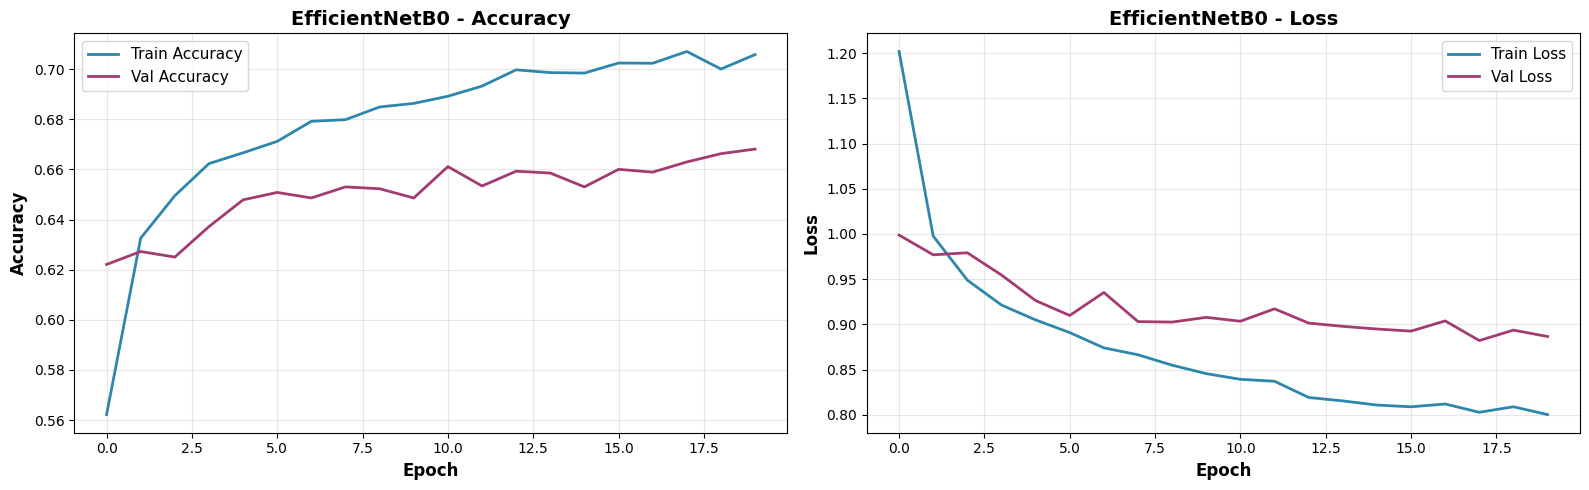

In [46]:
def plot_training_history(history, model_name):
    """Plot training and validation metrics"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#2E86AB')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#A23B72')
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, color='#2E86AB')
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#A23B72')
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
plot_training_history(history_eff, "EfficientNetB0")

In [48]:

# True labels from validation dataset
y_true_eff = np.concatenate([
    y.numpy() for x, y in val_ds_eff
])

# Model predictions
y_pred_probs = model_eff.predict(val_ds_eff)

# Convert probabilities to class index
y_pred_eff = np.argmax(y_pred_probs, axis=1)


85/85 [==============================] - 78s 871ms/step


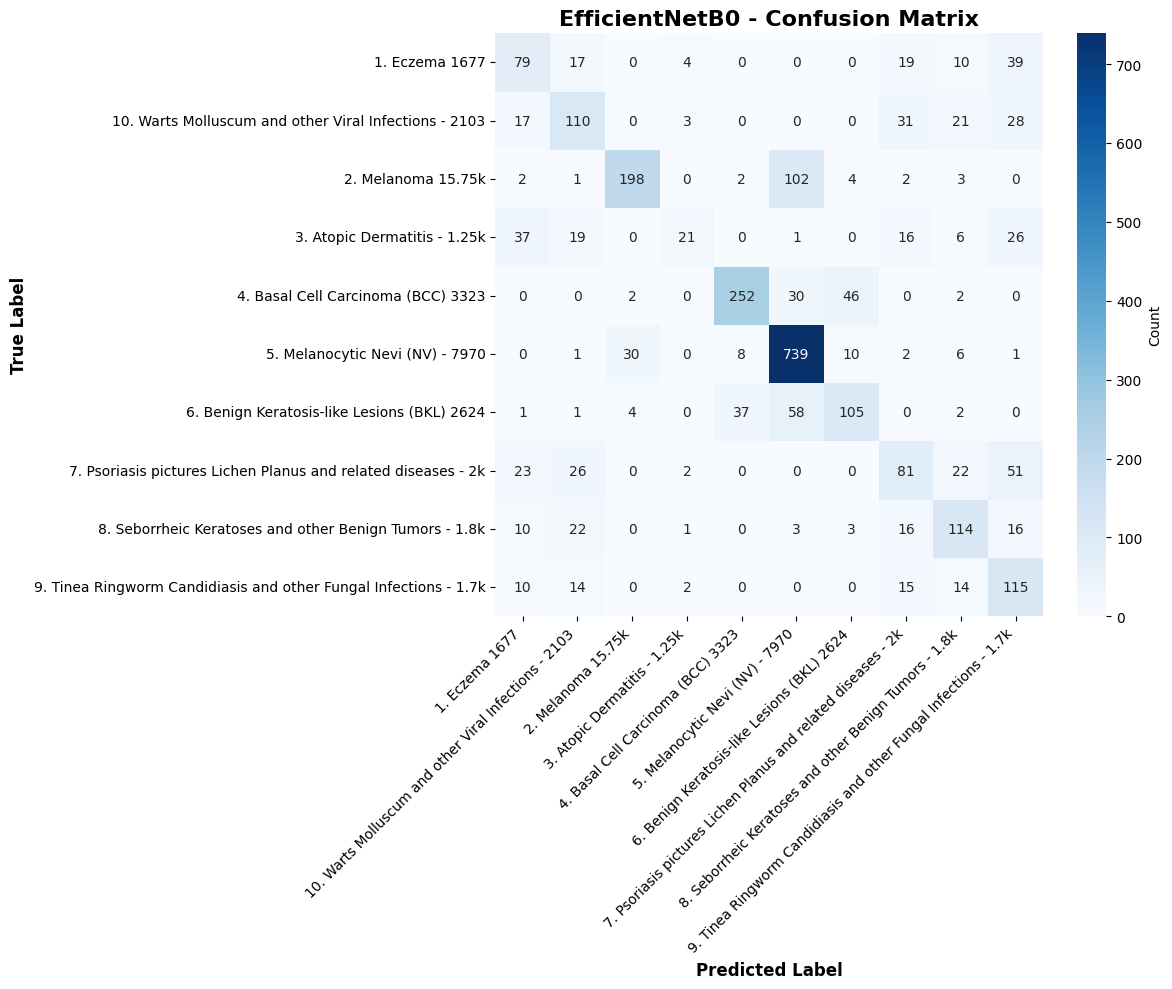

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

cm_eff = confusion_matrix(y_true_eff, y_pred_eff)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('EfficientNetB0 - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [52]:
model_eff.save('efficientnetb0_skin_disease_final.keras')
model_eff.save('efficientnetb0_skin_disease_final.h5')

c:\Users\VIMALA SRI\anaconda3\envs\derma-ai\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
